In [1]:
import sys
sys.path.insert(1, '/Users/Andrew/Documents/PhD/Scripts/Python/pygplates_rev12')
import pygplates
import points_in_polygons
import numpy as np
import pandas as pd
import pickle
import os
from mpl_toolkits.basemap import Basemap, shiftgrid
import matplotlib.pyplot as plt
from create_gpml import create_gpml_regular_long_lat_mesh
from skimage import measure

In [5]:
%matplotlib inline


basedir1 = '/Users/Andrew/Documents/EarthByte_Models/SVN/EByteDeformingModels'
basedir2 = '/Users/Andrew/Documents/PhD/Models/Rodinia_Models/Palaeozoic_Bridge'

COBterrane_file_410_0 = '%s/Matthews++_410-0Ma/StaticGeometries/AgeGridInput/Global_EarthByte_GeeK07_COB_Terranes_Matthews_etal.gpml' % basedir1
COBterrane_file_1000_410 = '%s/COBs_global_artificial.gpml' % basedir2
terrane_file = '%s/Topos_for_plotting/Neoproterozoic_Palaeozoic_Shapes_20170714_new-antarctica.gpml' %basedir2

#cs = pygplates.FeatureCollection('../pygplates-alpha/Data/Global_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpmlz')

rotation_file_410_250 = '%s/Matthews++_410-0Ma/Global_EB_410-250Ma_GK07_Matthews_etal.rot' % basedir1
rotation_file_250_0 = '%s/Matthews++_410-0Ma/Global_EB_250-0Ma_GK07_Matthews_etal.rot' % basedir1
rotation_file_1000_410 = '%s/Topos_for_plotting/1000-410_rotations(finished)_20170621a_north_china-tarim-aus.rot' % basedir2

topologies = ['%s/Topos_for_plotting/Convergence_20170716.gpml' %basedir2,
              '%s/Topos_for_plotting/Divergence_20170622.gpml' %basedir2,
              '%s/Topos_for_plotting/Transforms_20170716.gpml' %basedir2,
              '%s/Topos_for_plotting/Topologies_20170716.gpml' %basedir2]


cobter_1000_410 = pygplates.FeatureCollection(COBterrane_file_1000_410)
rotation_model_1000_410 = pygplates.RotationModel(rotation_file_1000_410)
terranes = pygplates.FeatureCollection(terrane_file)

cobter_410_0 = pygplates.FeatureCollection(COBterrane_file_410_0)
rotation_model_410_250 = pygplates.RotationModel(rotation_file_410_250)
rotation_model_250_0 = pygplates.RotationModel(rotation_file_250_0)


#for polygon in reconstructed_polygons:
#    for geometry in polygon.get_reconstructed_geometry():
#        for segment in geometry.get_points():
#            print segment


multipoints = create_gpml_regular_long_lat_mesh(1)

for multipoint in multipoints:
    for mp in multipoint.get_all_geometries():
        points = mp.to_lat_lon_point_list()



In [6]:
polygons = []
for feature in cobter_410_0:
    
    for geom in feature.get_geometries():
        polygon = []
        #print feature.get_geometry()
    
        polygon = feature
        polygon.set_geometry(pygplates.PolygonOnSphere(geom))

        #print polygon.get_geometry()

        polygons.append(polygon)

cobter_410_0 = pygplates.FeatureCollection(polygons)
#fc.write('pltest.gpmlz')

polygons = []
for feature in cobter_1000_410:
    
    for geom in feature.get_geometries():
        polygon = []
        #print feature.get_geometry()
    
        polygon = feature
        polygon.set_geometry(pygplates.PolygonOnSphere(geom))

        #print polygon.get_geometry()

        polygons.append(polygon)

cobter_1000_410 = pygplates.FeatureCollection(polygons)
#fc.write('pltest.gpmlz')




In [7]:
def run_grid_pip(time,points,polygons,rotation_model):
    
    reconstructed_polygons = []
    pygplates.reconstruct(polygons,rotation_model,reconstructed_polygons,time)
    
    rpolygons = []
    for polygon in reconstructed_polygons:
        #print polygon
        #if polygon.get_reconstructed_geometry() == 'PolygonOnSphere':
        if polygon.get_reconstructed_geometry():
            #print polygon.get_reconstructed_geometry()
            rpolygons.append(polygon.get_reconstructed_geometry())


    polygons_containing_points = points_in_polygons.find_polygons(points, rpolygons)

    lat = []
    lon = []
    zval = []
    
    for pcp,point in zip(polygons_containing_points,points):
        lat.append(point.get_latitude())
        lon.append(point.get_longitude())
        if pcp is not None:
            zval.append(1)
        else:
            zval.append(0)
            
    bi = np.array(zval).reshape(181,361)
    
    return bi


0
10
20
30
40
50
60
70
80
90
100
110


KeyboardInterrupt: 

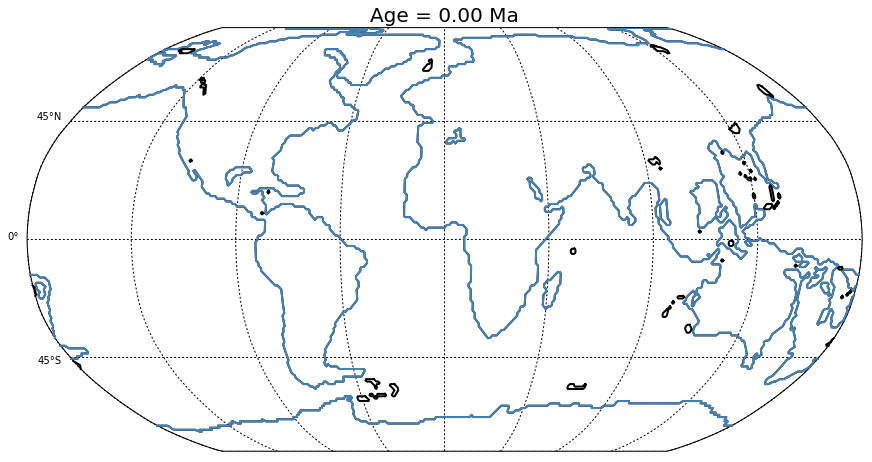

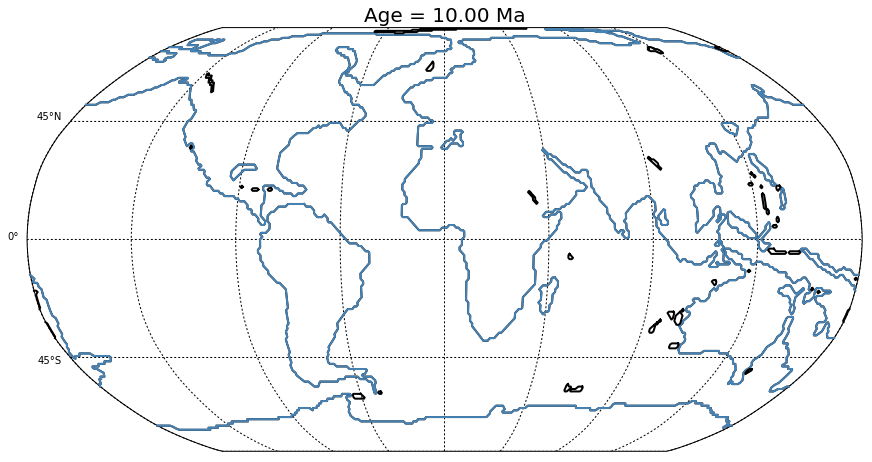

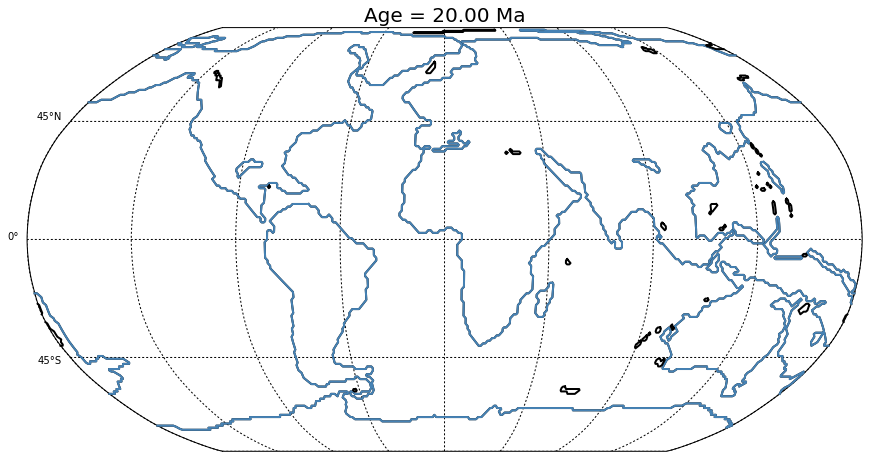

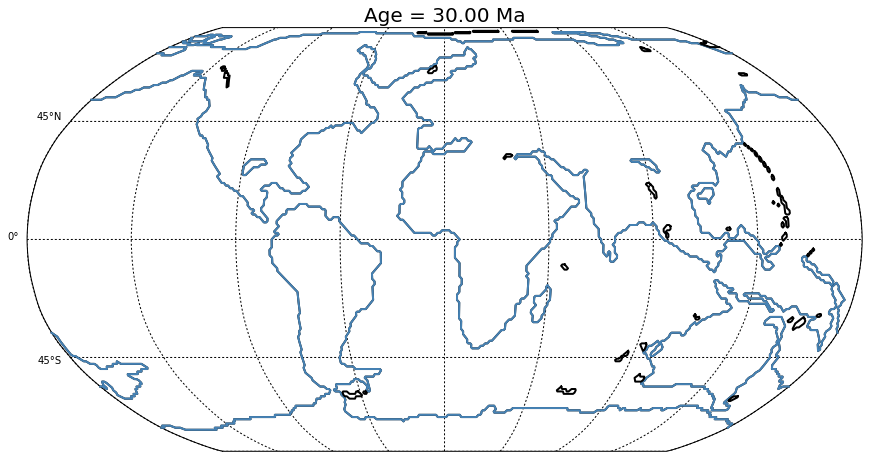

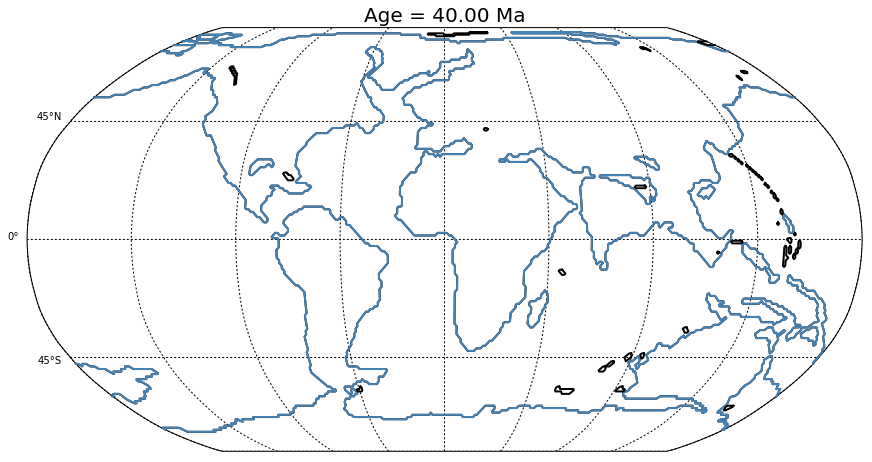

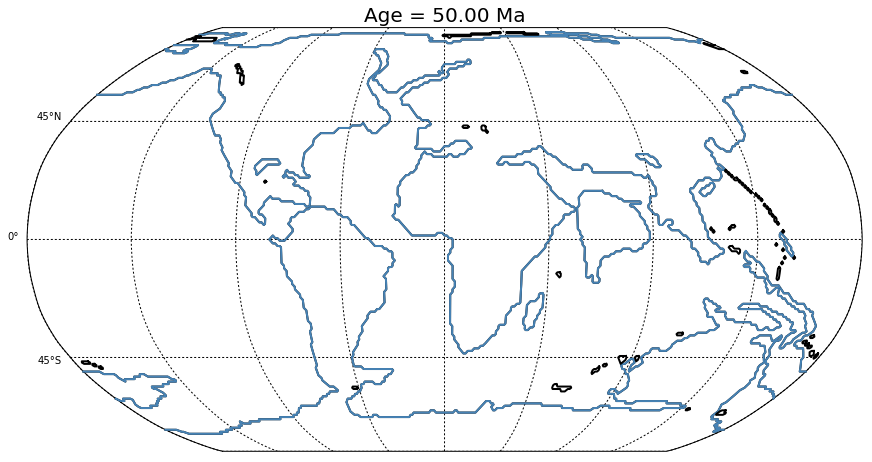

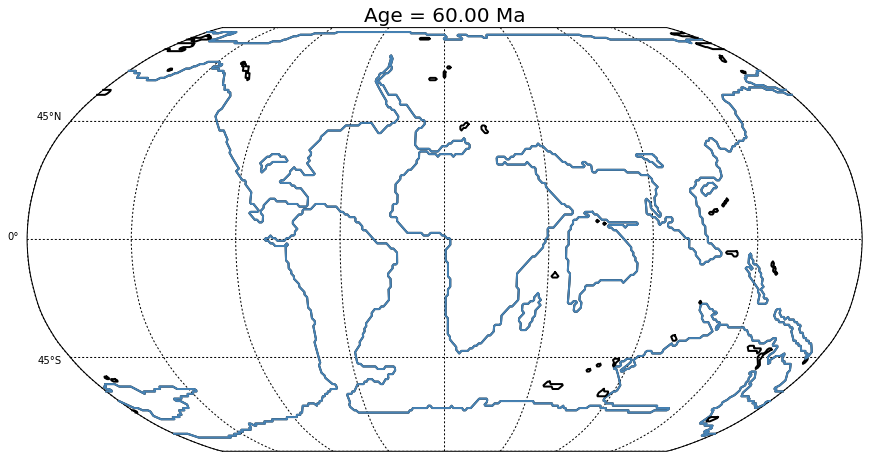

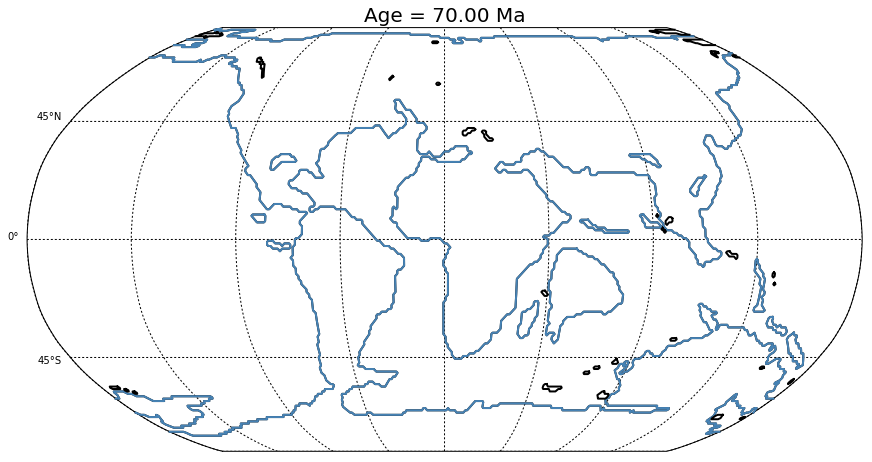

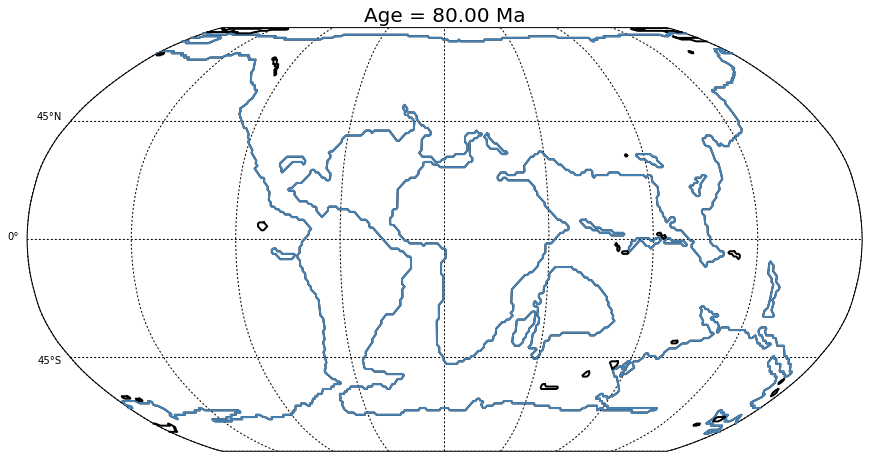

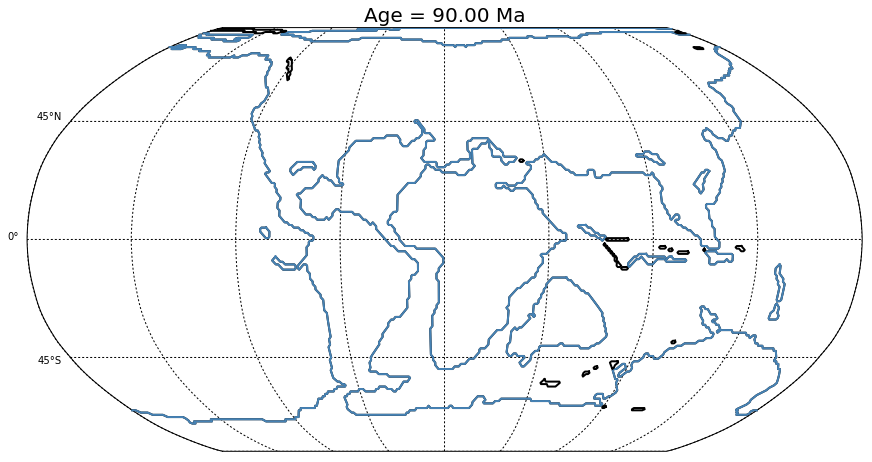

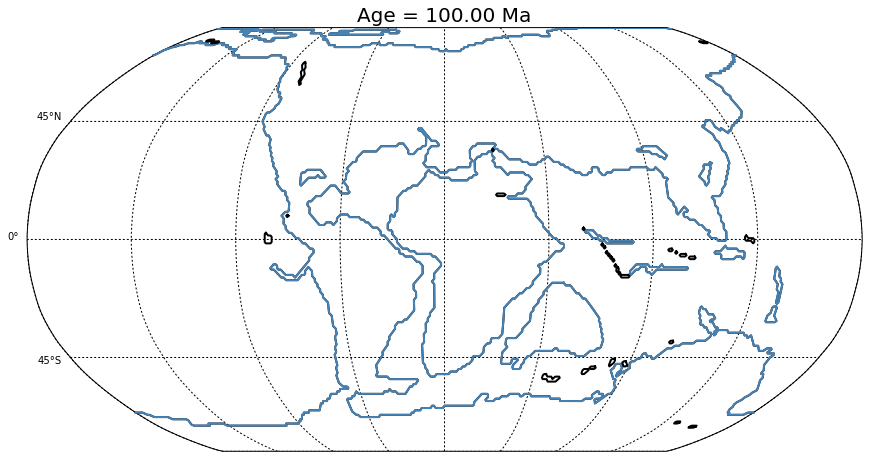

In [9]:
##extract data for 250-0 Ma

#plt.figure(figsize=(15,30))

for i,time in enumerate(np.arange(0,250,10)):
    print time
    bi = run_grid_pip(time,points,cobter_410_0,rotation_model_250_0)
    
    #plt.subplot(10,2,i+1)
    #plt.imshow(bi,origin='lower',extent=[0,360,0,180])

    # Find contours at a constant value of 0.8
    contours = measure.find_contours(bi, 0.5)
    
    contour_polygons = []
    for n,cp in enumerate(contours):
        cpf = pygplates.PolygonOnSphere(zip(cp[:,0]-90,cp[:,1]-180))
        contour_polygons.append(cpf)

    parea = 0.
    plen = 0.
    for pg in contour_polygons:
        if pg.get_area()>0.1:
            plen += pg.get_arc_length()*pygplates.Earth.mean_radius_in_kms
            #print pg.get_areax()*pygplates.Earth.mean_radius_in_kms**2
            parea += pg.get_area()

    #print parea/(4*np.pi), plen

    fig = plt.figure(figsize=(12,8))
    m1 = Basemap(resolution='c',projection='robin',lon_0=180.)
    clip_path = m1.drawmapboundary()
    m1.drawmeridians(np.arange(0, 360, 45),fontsize=10)
    m1.drawparallels(np.arange(-90, 90, 45), labels=[1,0,0,0],fontsize=10)
    ax = plt.gca()
    #print parea/(4*np.pi), plen
    for pg,contour in zip(contour_polygons,contours):
        #print pg.get_area()*pygplates.Earth.mean_radius_in_kms**2
        if pg.get_area()*pygplates.Earth.mean_radius_in_kms**2 > 5000:
            #print pg.get_area()*pygplates.Earth.mean_radius_in_kms**2
            lons = contour[:, 1]
            lats = contour[:, 0]
            lats = -90 + lats
#            print 'original', lats, 'new', lats1
            x_geom, y_geom = m1(lons, lats)
            m1.plot(x_geom, y_geom, 'k', linewidth=2)

        if pg.get_area()*pygplates.Earth.mean_radius_in_kms**2 > 125000:
            #print pg.get_area()*pygplates.Earth.mean_radius_in_kms**2
            lons1 = contour[:, 1]
            lats1 = contour[:, 0]
            lats1 = -90 + lats1
#            print 'original', lats, 'new', lats1
            x_geom1, y_geom1 = m1(lons1, lats1)
            m1.plot(x_geom1, y_geom1, '#4682b4', linewidth=2)
    
    plt.title('Age = %0.2f Ma' % (time), fontsize=20)
    plt.tight_layout()

    # Check for existing output directory and create it if not found
    if not os.path.exists("output"):
        os.makedirs("output")
    # Check for existing output file with same name and remove if found
    if os.path.isfile("output/" + str('%s') % time):
        os.remove("output/" + str('%s') % time)
        
    #plt.savefig('output/%s' % time)


In [ ]:
##extract data for 410-250 Ma

for i,time in enumerate(np.arange(250,410,10)):
    bi = run_grid_pip(time,points,cobter_410_0,rotation_model_410_250)
    
    #plt.subplot(10,2,i+1)
    #plt.imshow(bi,origin='lower',extent=[0,360,0,180])

    # Find contours at a constant value of 0.8
    contours = measure.find_contours(bi, 0.5)
    
    contour_polygons = []
    for n,cp in enumerate(contours):
        cpf = pygplates.PolygonOnSphere(zip(cp[:,0]-90,cp[:,1]-180))
        contour_polygons.append(cpf)

    parea = 0.
    plen = 0.
    for pg in contour_polygons:
        if pg.get_area()>0.1:
            plen += pg.get_arc_length()*pygplates.Earth.mean_radius_in_kms
            parea += pg.get_area()

    fig = plt.figure(figsize=(12,8))
    m1 = Basemap(resolution='c',projection='robin',lon_0=180.)
    clip_path = m1.drawmapboundary()
    m1.drawmeridians(np.arange(0, 360, 45),fontsize=10)
    m1.drawparallels(np.arange(-90, 90, 45), labels=[1,0,0,0],fontsize=10)
    ax = plt.gca()
    #print parea/(4*np.pi), plen
    for pg,contour in zip(contour_polygons,contours):
        #print pg.get_area()*pygplates.Earth.mean_radius_in_kms**2
        if pg.get_area()*pygplates.Earth.mean_radius_in_kms**2 > 5000:
            #print pg.get_area()*pygplates.Earth.mean_radius_in_kms**2
            lons = contour[:, 1]
            lats = contour[:, 0]
            lats = -90 + lats
#            print 'original', lats, 'new', lats1
            x_geom, y_geom = m1(lons, lats)
            m1.plot(x_geom, y_geom, 'k', linewidth=2)

        if pg.get_area()*pygplates.Earth.mean_radius_in_kms**2 > 1250000:
            #print pg.get_area()*pygplates.Earth.mean_radius_in_kms**2
            lons1 = contour[:, 1]
            lats1 = contour[:, 0]
            lats1 = -90 + lats1
#            print 'original', lats, 'new', lats1
            x_geom1, y_geom1 = m1(lons1, lats1)
            m1.plot(x_geom1, y_geom1, '#4682b4', linewidth=2)
    
    plt.title('Age = %0.2f Ma' % (time), fontsize=20)
    plt.tight_layout()
    
    # Check for existing output directory and create it if not found
    if not os.path.exists("output"):
        os.makedirs("output")

    # Check for existing output file with same name and remove if found
    if os.path.isfile("output/" + str('%s') % time):
        os.remove("output/" + str('%s') % time)
        
    #plt.savefig('output/%s' % time)

In [ ]:
#extract data for 1000-410

for i,time in enumerate(np.arange(410,1010,10)):

    bi = run_grid_pip(time,points,cobter_1000_410,rotation_model_1000_410)
    
    # Find contours at a constant value of 0.8
    contours = measure.find_contours(bi, 0.5)
    
    contour_polygons = []
    for n,cp in enumerate(contours):
        cpf = pygplates.PolygonOnSphere(zip(cp[:,0]-90,cp[:,1]-180))
        contour_polygons.append(cpf)

    parea = 0.
    plen = 0.
    for pg in contour_polygons:
        if pg.get_area()>0.1:
            plen += pg.get_arc_length()*pygplates.Earth.mean_radius_in_kms
            parea += pg.get_area()

    #print parea/(4*np.pi), plen

    fig = plt.figure(figsize=(12,8))
    m1 = Basemap(resolution='c',projection='robin',lon_0=180.)
    clip_path = m1.drawmapboundary()
    m1.drawmeridians(np.arange(0, 360, 45),fontsize=10)
    m1.drawparallels(np.arange(-90, 90, 45), labels=[1,0,0,0],fontsize=10)
    ax = plt.gca()
    #print parea/(4*np.pi), plen
    for pg,contour in zip(contour_polygons,contours):
        #print pg.get_area()*pygplates.Earth.mean_radius_in_kms**2
        if pg.get_area()*pygplates.Earth.mean_radius_in_kms**2 > 5000:
            #print pg.get_area()*pygplates.Earth.mean_radius_in_kms**2
            lons = contour[:, 1]
            lats = contour[:, 0]
            lats = -90 + lats
#            print 'original', lats, 'new', lats1
            x_geom, y_geom = m1(lons, lats)
            m1.plot(x_geom, y_geom, 'k', linewidth=2)

        if pg.get_area()*pygplates.Earth.mean_radius_in_kms**2 > 1250000:
            #print pg.get_area()*pygplates.Earth.mean_radius_in_kms**2
            lons1 = contour[:, 1]
            lats1 = contour[:, 0]
            lats1 = -90 + lats1
#            print 'original', lats, 'new', lats1
            x_geom1, y_geom1 = m1(lons1, lats1)
            m1.plot(x_geom1, y_geom1, '#4682b4', linewidth=2)
    
    plt.title('Age = %0.2f Ma' % (time), fontsize=20)
    plt.tight_layout()
       
    # Check for existing output directory and create it if not found
    if not os.path.exists("output"):
        os.makedirs("output")

    # Check for existing output file with same name and remove if found
    if os.path.isfile("output/" + str('%s') % time):
        os.remove("output/" + str('%s') % time)
        
    #plt.savefig('output/%s' % time)

In [ ]:
#save specific timeslots for figures


bi = run_grid_pip(50,points,cobter_410_0,rotation_model_250_0)

#plt.subplot(10,2,i+1)
#plt.imshow(bi,origin='lower',extent=[0,360,0,180])

# Find contours at a constant value of 0.8
contours = measure.find_contours(bi, 0.5)

contour_polygons = []
for n,cp in enumerate(contours):
    cpf = pygplates.PolygonOnSphere(zip(cp[:,0]-90,cp[:,1]-180))
    contour_polygons.append(cpf)

parea = 0.
plen = 0.
for pg in contour_polygons:
    if pg.get_area()>0.1:
        plen += pg.get_arc_length()*pygplates.Earth.mean_radius_in_kms
        parea += pg.get_area()

fig = plt.figure(figsize=(12,8))
m1 = Basemap(resolution='c',projection='robin',lon_0=180.)
clip_path = m1.drawmapboundary()
m1.drawmeridians(np.arange(0, 360, 45),fontsize=10)
m1.drawparallels(np.arange(-90, 90, 45), labels=[1,0,0,0],fontsize=10)
ax = plt.gca()
#print parea/(4*np.pi), plen
for pg,contour in zip(contour_polygons,contours):
    #print pg.get_area()*pygplates.Earth.mean_radius_in_kms**2
    if pg.get_area()*pygplates.Earth.mean_radius_in_kms**2 > 10000:
        #print pg.get_area()*pygplates.Earth.mean_radius_in_kms**2
        lons = contour[:, 1]
        lats = contour[:, 0]
        lats = -90 + lats
#            print 'original', lats, 'new', lats1
        x_geom, y_geom = m1(lons, lats)
        m1.plot(x_geom, y_geom, 'k', linewidth=2)

    if pg.get_area()*pygplates.Earth.mean_radius_in_kms**2 > 5000000:
        #print pg.get_area()*pygplates.Earth.mean_radius_in_kms**2
        lons1 = contour[:, 1]
        lats1 = contour[:, 0]
        lats1 = -90 + lats1
#            print 'original', lats, 'new', lats1
        x_geom1, y_geom1 = m1(lons1, lats1)
        m1.plot(x_geom1, y_geom1, '#4682b4', linewidth=2)

plt.title('Age = %0.2f Ma' % (50), fontsize=20)
plt.tight_layout()

plt.savefig('%s_snapshot.svg' % 50)


In [10]:
contour_polygons = []
for n,cp in enumerate(contours):
    cpf = pygplates.PolygonOnSphere(zip(cp[:,0]-90,cp[:,1]-180))
    contour_polygons.append(cpf)

parea = 0.
plen = 0.
for pg in contour_polygons:
    if pg.get_area()>0.01:
        plen += pg.get_arc_length()*pygplates.Earth.mean_radius_in_kms
        parea += pg.get_area()
    
print parea/(4*np.pi), plen


0.794351112366 222976.843879


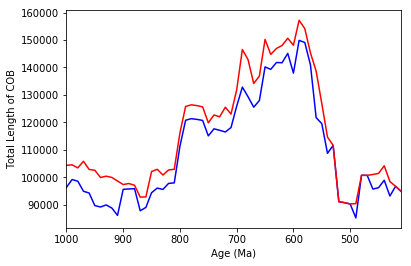

In [11]:
plen_list_1000_410 = []
plen_list2_1000_410 = []
time_list = np.arange(410,1010,10)

for i,time in enumerate(time_list):
    #print time
    
    bi = run_grid_pip(time,points,cobter_1000_410,rotation_model_1000_410)
    
    # Find contours at a constant value of 0.8
    contours = measure.find_contours(bi, 0.5)
    
    contour_polygons = []
    for n,cp in enumerate(contours):
        cpf = pygplates.PolygonOnSphere(zip(cp[:,0]-90,cp[:,1]-180))
        contour_polygons.append(cpf)

    parea = 0.
    plen = 0.
    plen2 = 0.
    for pg in contour_polygons:
        if pg.get_area()*pygplates.Earth.mean_radius_in_kms**2 > 1250000:
            plen += pg.get_arc_length()*pygplates.Earth.mean_radius_in_kms
        if pg.get_area()*pygplates.Earth.mean_radius_in_kms**2 > 10000:
            plen2 += pg.get_arc_length()*pygplates.Earth.mean_radius_in_kms
            
    plen_list_1000_410.append(plen)
    plen_list2_1000_410.append(plen2)

    
plt.plot(time_list,plen_list_1000_410,'b')
plt.plot(time_list,plen_list2_1000_410,'r')
plt.xlabel('Age (Ma)')
plt.ylabel('Total Length of COB')
plt.xlim(1000,410,40)
plt.show()

with open('plen_list', 'wb') as fp:
    pickle.dump(plen_list_1000_410, fp)
with open('plen_list2', 'wb') as fp:
    pickle.dump(plen_list2_1000_410, fp)

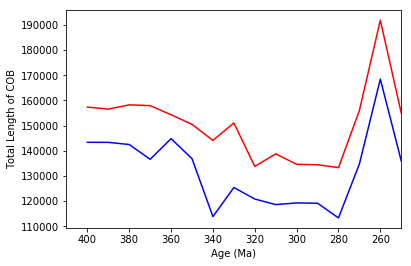

In [12]:
plen_list_410_250 = []
plen_list2_410_250 = []
time_list = np.arange(250,410,10)

for i,time in enumerate(time_list):
    #print time
    
    bi = run_grid_pip(time,points,cobter_410_0,rotation_model_410_250)
    
    # Find contours at a constant value of 0.8
    contours = measure.find_contours(bi, 0.5)
    
    contour_polygons = []
    for n,cp in enumerate(contours):
        cpf = pygplates.PolygonOnSphere(zip(cp[:,0]-90,cp[:,1]-180))
        contour_polygons.append(cpf)

    parea = 0.
    plen = 0.
    plen2 = 0.
    for pg in contour_polygons:
        if pg.get_area()*pygplates.Earth.mean_radius_in_kms**2 > 1250000:
            plen += pg.get_arc_length()*pygplates.Earth.mean_radius_in_kms
        if pg.get_area()*pygplates.Earth.mean_radius_in_kms**2 > 10000:
            plen2 += pg.get_arc_length()*pygplates.Earth.mean_radius_in_kms
            
    plen_list_410_250.append(plen)
    plen_list2_410_250.append(plen2)

    
plt.plot(time_list,plen_list_410_250,'b')
plt.plot(time_list,plen_list2_410_250,'r')
plt.xlabel('Age (Ma)')
plt.ylabel('Total Length of COB')
plt.xlim(410,250,40)
plt.show()

with open('plen_list', 'wb') as fp:
    pickle.dump(plen_list_410_250, fp)
with open('plen_list2', 'wb') as fp:
    pickle.dump(plen_list2_410_250, fp)

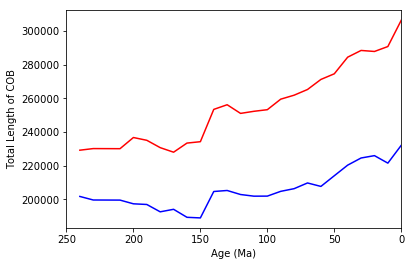

In [13]:
plen_list_250_0 = []
plen_list2_250_0 = []
time_list = np.arange(0,250,10)

for i,time in enumerate(time_list):
    #print time
    
    bi = run_grid_pip(time,points,cobter_410_0,rotation_model_410_250)
    
    # Find contours at a constant value of 0.8
    contours = measure.find_contours(bi, 0.5)
    
    contour_polygons = []
    for n,cp in enumerate(contours):
        cpf = pygplates.PolygonOnSphere(zip(cp[:,0]-90,cp[:,1]-180))
        contour_polygons.append(cpf)

    parea = 0.
    plen = 0.
    plen2 = 0.
    for pg in contour_polygons:
        if pg.get_area()*pygplates.Earth.mean_radius_in_kms**2 > 1250000:
            plen += pg.get_arc_length()*pygplates.Earth.mean_radius_in_kms
        if pg.get_area()*pygplates.Earth.mean_radius_in_kms**2 > 10000:
            plen2 += pg.get_arc_length()*pygplates.Earth.mean_radius_in_kms
            
    plen_list_250_0.append(plen)
    plen_list2_250_0.append(plen2)

    
plt.plot(time_list,plen_list_250_0,'b')
plt.plot(time_list,plen_list2_250_0,'r')
plt.xlabel('Age (Ma)')
plt.ylabel('Total Length of COB')
plt.xlim(250,0,40)
plt.show()

with open('plen_list', 'wb') as fp:
    pickle.dump(plen_list_250_0, fp)
with open('plen_list2', 'wb') as fp:
    pickle.dump(plen_list2_250_0, fp)

In [14]:
plen_merge = np.concatenate((np.asarray(plen_list_250_0),np.asarray(plen_list_410_250),np.asarray(plen_list_1000_410)))
plen_merge2 = np.concatenate((np.asarray(plen_list2_250_0),np.asarray(plen_list2_410_250),np.asarray(plen_list2_1000_410)))

In [15]:
with open('plen_merge_1250000', 'wb') as fp:
    pickle.dump(plen_merge, fp)
with open('plen_merge_10000', 'wb') as fp:
    pickle.dump(plen_merge2, fp)

In [16]:
time_test = np.arange(0,1010,10)

(1000, 0)

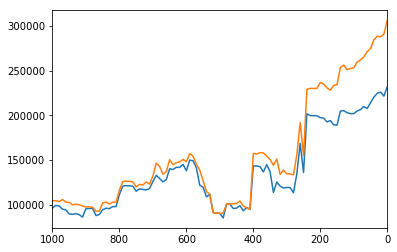

In [17]:
plt.plot(time_test,plen_merge)
plt.plot(time_test,plen_merge2)
plt.xlim(1000,0,10)

In [ ]:
total_continental_arc_length = []
for time in range(520, num_of_time_steps + 1, 1):
#time = 750
    resolved_topologies = []
    shared_boundary_sections = []
    all_tesselated_shared_sub_segmentsub_segment = []
    continental_arcs = []
    reconstructed_COBs = []


    pygplates.resolve_topologies(topologies, rotation_model, resolved_topologies, time, shared_boundary_sections)
    pygplates.reconstruct(cobter_1000_410, rotation_model, reconstructed_COBs, time)

    #count = 0.
    total_length = 0.

    #plt.figure()
    #lon=[]
    #lat=[]

    for shared_boundary_section in shared_boundary_sections:

        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:

            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                tmp = shared_sub_segment.get_resolved_geometry()
                tesselated_shared_sub_segment = tmp.to_tessellated(np.radians(0.1))      

                all_tesselated_shared_sub_segment.append(tesselated_shared_sub_segment)

                for segment in tesselated_shared_sub_segment.get_segments():
                    #print vertex
                    count = 0.
                    for COB in reconstructed_COBs:
                        #print COB.get_reconstructed_geometry()
                        distance_radians = pygplates.GeometryOnSphere.distance(segment.get_arc_point(0.5), 
                                                                               COB.get_reconstructed_geometry())
                        distance_kms = distance_radians * pygplates.Earth.mean_radius_in_kms
                        #filtered_distance = []
                        if distance_kms < 200:
                            #filtered_distance.append(distance_kms)
                            total_length += segment.get_arc_length() * pygplates.Earth.mean_radius_in_kms
                            count+=1.
                            if count > 1:
                                print 'Double-Dipping!!'
                            #tmp = segment.get_arc_point(0.5)
                            #print tmp.to_lat_lon()
                            #lon.append(segment.get_arc_point(0.5).to_lat_lon()[1])
                            #lat.append(segment.get_arc_point(0.5).to_lat_lon()[0])

                            break
    total_continental_arc_length.append(total_length)
                        #print filtered_distance


    print time,count,total_length
    #print total_continental_arc_length
    #plt.plot(lon,lat,'.')
    #plt.xlim(-180,180)
    #plt.ylim(-90,90)
